# Implementation of PeakFinder8 on GPU

The *peakfinder8* is the core algorithm for assessing the quality of a single frame in serial crystallography and was initially implemented in C++ within the [cheetah](https://www.desy.de/~barty/cheetah/Cheetah/SFX_hitfinding.html) [1]

This algorithm is called *peakfinder8* because it consits of 8 subsequent steps perfromed on evry single frame:

1. perfrom the azimuthal integration with uncertainety propagation
2. discard pixels which differ by more than N-sigma from the mean and cycle to 1 about 3 to 5 times
3. pick all pixels with I > mean + min(N*sigma, noise)
4. such pixel is a peak if it is the maximum of the 3x3 or 5x5 patch and there are *connected* pixels in the patch with their intensity above the previous threshold.
5. subtract background and sum the signal over the patch
6. return the index of the peak, the integrated signal and the center of mass of the peak
7. exclude neighboring peaks (un-implemented)
8. Validate the frame if there are enough peaks found.

There is a attempt to implement *peakfinder8* on GPU within the pyFAI.
The steps 1+2 correspond to the sigma-clipping algorithm and enforce an azimuthal, normal distribution for the background.

This tutorial demontrates how peak-finding can be called from Jupyter notebooks and what are the performances expected. Finally, the performances will be compared with the reference implementation.


[1] A. Barty, R. A. Kirian, F. R. N. C. Maia, M. Hantke, C. H. Yoon, T. A. White, and H. N. Chapman, "Cheetah: software for high-throughput reduction and analysis of serial femtosecond x-ray diffraction data", J Appl Crystallogr, vol. 47, pp. 1118-1131 (2014)

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import os
import sys
import shutil
import posixpath
import numpy
import glob
from matplotlib.pylab import subplots
import fabio
import pyFAI, pyFAI.azimuthalIntegrator
from pyFAI.gui import jupyter
from pyFAI import units
import pyopencl
from pyFAI.opencl.peak_finder import OCL_PeakFinder
from pyFAI.test.utilstest import UtilsTest
from pyFAI.containers import ErrorModel
import time
start_time = time.perf_counter()
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

In [3]:
fimg = fabio.open(UtilsTest.getimage("Pilatus6M.cbf"))
mask = numpy.logical_or(fimg.data>65000, fimg.data<0)
print(f"Number of masked pixels: {mask.sum()}")

Number of masked pixels: 527055


In [4]:
det = pyFAI.detector_factory("Pilatus6M")
det.mask = mask

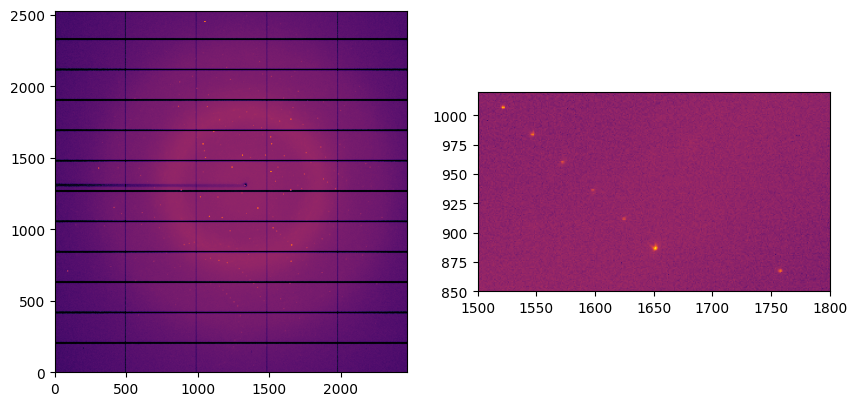

In [5]:
dimg = fimg.data.copy()
dimg[mask] = 0

fig,ax = subplots(1, 2, figsize=(10,5))
jupyter.display(dimg, ax=ax[0])
jupyter.display(dimg, ax=ax[1])
ax[1].set_xlim(1500, 1800)
ax[1].set_ylim(850, 1020)
pass

In [6]:
ponifile = UtilsTest.getimage("Pilatus6M.poni")
ai = pyFAI.load(ponifile)
ai.detector = det
print(ai)

Detector Pilatus 6M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033200e-10 m
SampleDetDist= 3.000000e-01 m	PONI= 2.254060e-01, 2.285880e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 300.000 mm	Center: x=1329.000, y=1310.500 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.033Å


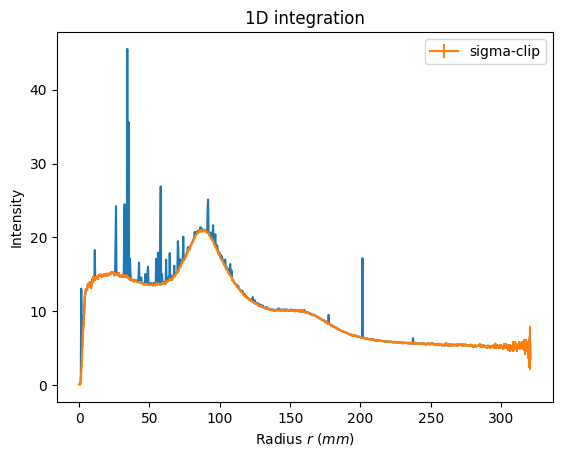

In [7]:
kwargs = {"data": fimg.data,
          "npt":1000, 
          "method": ("no", "csr", "opencl"), 
          "polarization_factor": 0.99, 
          "unit":"r_mm", }
ax = jupyter.plot1d(ai.integrate1d(**kwargs))
ax.errorbar(*ai.sigma_clip_ng(error_model="azimuthal", **kwargs), label="sigma-clip")
_=ax.legend()

In [8]:
ctx = pyopencl.create_some_context(interactive=False)
print(f"Using {ctx.devices[0].name}")

Using NVIDIA RTX A5000


In [9]:
unit = units.to_unit("r_mm")
image_size = det.shape[0] * det.shape[1]
integrator = ai.setup_sparse_integrator(ai.detector.shape, 1000, mask=mask, unit=unit, split="no", algo="CSR", scale=False)
polarization = ai._cached_array["last_polarization"]
pf = OCL_PeakFinder(integrator.lut, 
                     image_size=image_size,
                     bin_centers=integrator.bin_centers,
                     radius=ai._cached_array[unit.name.split("_")[0] + "_center"],
                     mask=mask,
                     ctx=ctx,
#                      block_size=512,
                     unit=unit) 
kwargs = {"data":fimg.data, 
          "error_model": ErrorModel.parse("azimuthal"), 
          "polarization":polarization.array,
          "polarization_checksum": polarization.checksum}
print(f"Number of high intensity pixels at stage #3:\t{pf.count_intense(**kwargs ,cycle=5, cutoff_pick=3.0)}\n\
Number of peaks identified at stage #6:\t\t{pf._count_peak(**kwargs, cycle=5, cutoff_peak=3.0)}")

Number of high intensity pixels at stage #3:	19464
Number of peaks identified at stage #6:		340


In [10]:
from silx.opencl.processing import ProfileDescription, EventDescription

def average_opencl_runtime(events):
    stats = {}
    total_time = 0.0
    for e in events:
        if isinstance(e, ProfileDescription):
            name = e[0]
            t0 = e[1]
            t1 = e[2]
        elif isinstance(e, EventDescription) or "__len__" in dir(e) and len(e) == 2:
            name = e[0]
            pr = e[1].profile
            t0 = pr.start
            t1 = pr.end
        else:
            name = "?"
            t0 = e.profile.start
            t1 = e.profile.end

        et = 1e-6 * (t1 - t0)
        total_time += et
        if name in stats:
            stats[name].append(et)
        else:
            stats[name] = [et]
    return total_time/max(len(stats[i]) for i in stats)

In [11]:
# Performance measurement of the pixel recording (stage 1->3)
pf.reset_log()
pf.set_profiling(True)
timeit_count_intense = %timeit -o pf.count(**kwargs, cycle=3, cutoff_pick=3, noise=1)
print("\n".join(pf.log_profile(True)))
print(f"Overhead due to Python: {(0.001*average_opencl_runtime(pf.events)/timeit_count_intense.average-1.0)*-100:.1f}%")
pf.set_profiling(False)

5.83 ms ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_PeakFinder
                                       Kernel name (count):      min   median      max     mean      std
                               copy H->D image_raw (  811):    2.221    2.376    4.462    2.380    0.112
                                         memset_ng (  811):    0.003    0.012    0.034    0.012    0.003
                                     corrections4a (  811):    0.259    0.262    0.299    0.262    0.002
                                   csr_sigma_clip4 (  811):    2.275    2.292    2.507    2.298    0.031
                                    memset counter (  811):    0.002    0.003    0.012    0.003    0.000
                                      find_intense (  811):    0.355    0.358    0.368    0.359    0.001
                                 copy D->H counter (  811):    0.001    0.001    0.010    0.001    0.000
________________

The overhead from calling OpenCL from Python is as low as 8%

In [12]:
# Performance measurement of the pixel recording (stage 1->6)
pf.reset_log()
pf.set_profiling(True)
timeit_gpu = %timeit -o pf.peakfinder8(**kwargs, cycle=3, cutoff_peak=3, noise=1, connected=3, patch_size=3)
print("\n".join(pf.log_profile(True)))
print(f"Overhead due to Python: {(0.001*average_opencl_runtime(pf.events)/timeit_gpu.average-1.0)*-100:.1f}%")
pf.set_profiling(False)

6.68 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_PeakFinder
                                       Kernel name (count):      min   median      max     mean      std
                               copy H->D image_raw (  811):    2.223    2.378    4.484    2.383    0.128
                                         memset_ng (  811):    0.003    0.012    0.043    0.012    0.003
                                     corrections4a (  811):    0.257    0.259    0.274    0.259    0.002
                                   csr_sigma_clip4 (  811):    2.274    2.290    2.483    2.292    0.025
                                    memset counter (  811):    0.002    0.003    0.004    0.003    0.000
                                        peakfinder (  811):    1.106    1.114    1.116    1.112    0.004
                                 copy D->H counter (  811):    0.001    0.001    0.002    0.001    0.000
                

The overhead from calling OpenCL from Python is as low as 10% (lower performances due to memory allocation)

In [13]:
# Visualization of the performances:
res8 = pf.peakfinder8(fimg.data, error_model="azimuthal", 
                      cycle=3, cutoff_peak=3, noise=2, connected=9, patch_size=5)
print(len(res8), res8.dtype)

128 [('index', '<i4'), ('intensity', '<f4'), ('sigma', '<f4'), ('pos0', '<f4'), ('pos1', '<f4')]


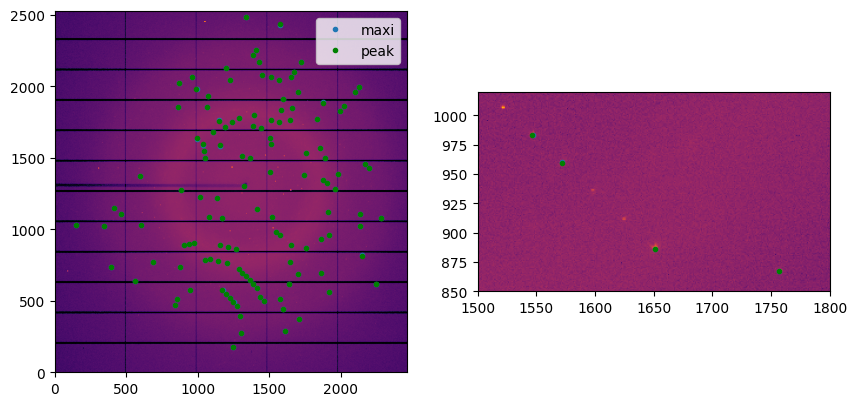

In [14]:
width = fimg.shape[-1]
y = res8["index"] // width
x = res8["index"] % width
fig, ax = subplots(1, 2, figsize=(10,5))
jupyter.display(dimg, ax=ax[0])
jupyter.display(dimg, ax=ax[1])
ax[0].plot(x, y, ".", label="maxi")
ax[1].plot(x, y, ".")
ax[0].plot(res8["pos1"], res8["pos0"], ".g", label="peak")
ax[1].plot(res8["pos1"], res8["pos0"], ".g")
ax[1].set_xlim(1500, 1800)
ax[1].set_ylim(850, 1020)
_=ax[0].legend()

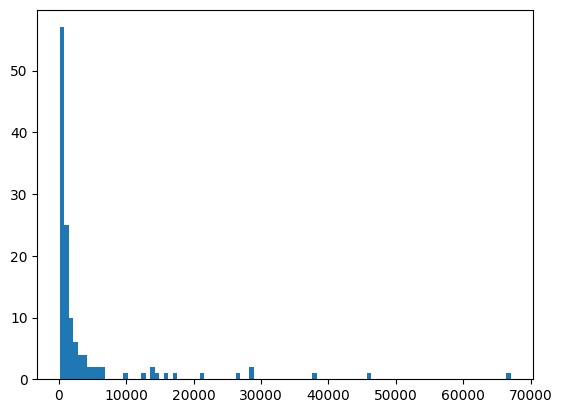

In [15]:
fig,ax = subplots()
res=ax.hist(res8["intensity"], 100, )

## Comparison with the original "peakfinder8" 

This algorithm has a python wrapper available from 
https://github.com/tjlane/peakfinder8

The next cells installs a local version of the Cython-binded peakfinder8 from github. 

Nota: This is a quick & dirty solution.

In [16]:
targeturl = "https://github.com/kif/peakfinder8"
targetdir = posixpath.split(targeturl)[-1]
if os.path.exists(targetdir):
    shutil.rmtree(targetdir, ignore_errors=True)
pwd = os.getcwd()
try:
    os.system("git clone " + targeturl)
    os.chdir(targetdir)
    os.system(f"'{sys.executable}' setup.py build")
finally:
    os.chdir(pwd)
sys.path.append(pwd+"/"+glob.glob(f"{targetdir}/build/lib*")[0])
from ssc.peakfinder8_extension import peakfinder_8

Cloning into 'peakfinder8'...
/users/kieffer/.venv/py312/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /users/kieffer/workspace-400/pyFAI/doc/source/usage/tutorial/Separation/peakfinder8/ext/peakfinder8/peakfinder8_extension.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Compiling ext/peakfinder8/peakfinder8_extension.pyx because it changed.
[1/1] Cythonizing ext/peakfinder8/peakfinder8_extension.pyx


In file included from /users/kieffer/.venv/py312/lib/python3.12/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909,
                 from /users/kieffer/.venv/py312/lib/python3.12/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /users/kieffer/.venv/py312/lib/python3.12/site-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from ext/peakfinder8/peakfinder8_extension.cpp:1270:
/users/kieffer/.venv/py312/lib/python3.12/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
ext/peakfinder8/peakfinders.cpp: In function ‘int peakfinder3(tPeakList*, float*, char*, long int, long int, long int, long int, float, float, long int, long int, long int)’:
ext/peakfinder8/peakfinders.cpp:319:57: warning: variable ‘thisr

In [17]:
%%time 
#Create some compatibility layer:
img = fimg.data.astype("float32")
r = ai._cached_array['r_center'].astype("float32")
# r = numpy.ones_like(img)
imask = (1-mask).astype("int8")
max_num_peaks = 1000
asic_nx = img.shape[-1]
asic_ny = img.shape[0]
nasics_x = 1
nasics_y = 1
adc_threshold = 2.0
minimum_snr = 3.0
min_pixel_count = 9
max_pixel_count = 999
local_bg_radius = 3 
accumulated_shots = 1
min_res = 0
max_res = 3000


CPU times: user 22.4 ms, sys: 16.2 ms, total: 38.6 ms
Wall time: 36.9 ms


In [18]:
%%time 
ref = peakfinder_8(max_num_peaks,
                   img, imask, r, 
                   asic_nx, asic_ny, nasics_x, nasics_y, 
                   adc_threshold, minimum_snr,
                   min_pixel_count, max_pixel_count, local_bg_radius)

CPU times: user 124 ms, sys: 15.6 ms, total: 139 ms
Wall time: 138 ms


In [19]:
timeit_cpu = %timeit -o peakfinder_8(max_num_peaks, img, imask, r, asic_nx, asic_ny, nasics_x, nasics_y, adc_threshold, minimum_snr,min_pixel_count, max_pixel_count, local_bg_radius)

141 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print("Number of peak found: ", len(ref[0]), len(ref[1]), len(ref[2]))
print("Speed up of GPU vs CPU: ", timeit_cpu.best/timeit_gpu.best)

Number of peak found:  995 995 995
Speed up of GPU vs CPU:  20.074882198104135


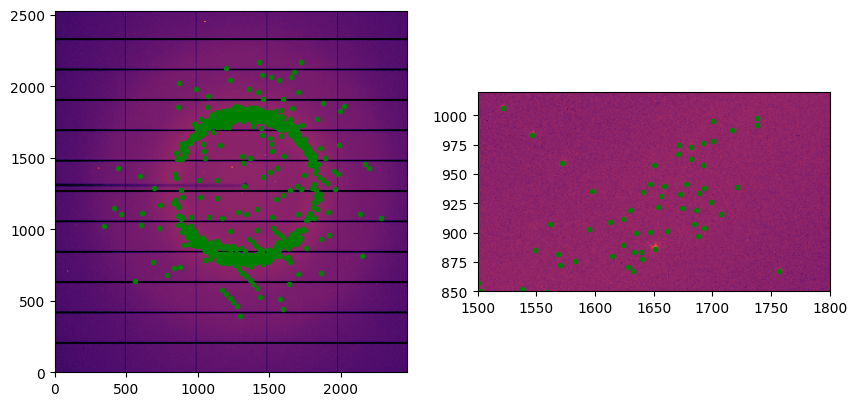

In [21]:
#Display the peaks
fig, ax = subplots(1, 2, figsize=(10,5))
jupyter.display(dimg, ax=ax[0])
jupyter.display(dimg, ax=ax[1])
ax[0].plot(ref[0], ref[1], ".g")
ax[1].plot(ref[0], ref[1], ".g")
ax[1].set_xlim(1500, 1800)
ax[1].set_ylim(850, 1020)
pass

## Conclusion

The re-implementation of *peakfinder8* in pyFAI takes advantage of the many parallel threads available on GPU which makes it 20 times faster than the original implementation in C++. Despite this algorithm has been re-designed for GPU, it can also run on CPU but it would not be optimized there thus it is likely to be slower.

The results obtained with the Python/OpenCL implementation looks better, this is probably due to a slightly different threshold $I > mean + max(N*sigma, noise)$ instead of $I > max(noise, mean + N*sigma)$.

In [22]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s")

Total execution time: 40.626s
